Semi-major axis: 0.6722342195133493
Semi-minor axis: 3.4017396012427294
Center: (5.695481046529727, 3.6267963571090593)
Rotation angle: -0.812727755924132


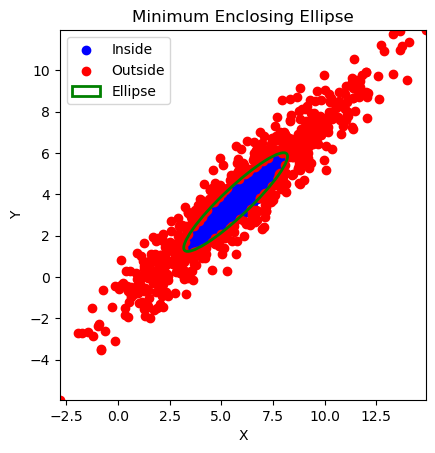

(0.6722342195133493,
 3.4017396012427294,
 -0.812727755924132,
 5.695481046529727,
 3.6267963571090593)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from matplotlib.patches import Ellipse


def ellipse_contains_point(a, b, theta, center, point):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    x, y = point
    x0, y0 = center
    
    term1 = ((cos_theta * (x - x0) + sin_theta * (y - y0)) ** 2) / (a ** 2)
    term2 = ((sin_theta * (x - x0) - cos_theta * (y - y0)) ** 2) / (b ** 2)
    
    return term1 + term2 <= 1

def ellipse_contains_point_noTrig(a, b, precalcTrig, center, point):
    x, y = point
    x0, y0 = center
    cos_theta, sin_theta = precalcTrig
    
    term1 = ((cos_theta * (x - x0) + sin_theta * (y - y0)) ** 2) / (a ** 2)
    term2 = ((sin_theta * (x - x0) - cos_theta * (y - y0)) ** 2) / (b ** 2)
    
    return term1 + term2 <= 1

def count_points_in_ellipse(a, b, theta, center, points):
    count = 0
    precalcTrig = (np.cos(theta), np.sin(theta))
    for point in points:
        #if ellipse_contains_point(a, b, theta, center, point):
        if ellipse_contains_point_noTrig(a, b, precalcTrig, center, point):
            count += 1
    return count

def objective(params, points, containedFrac):
    a, b, theta, x0, y0 = params
    center = (x0, y0)
    
    if a <= 0 or b <= 0:
        return np.inf

    numContainedPoints = count_points_in_ellipse(a, b, theta, center, points)
    
    if  numContainedPoints >= containedFrac*len(points):
        return a * b
        
    else:
        #return np.inf
        return (1e100)*(len(points) - numContainedPoints) #Instead of just giving infinity, give a number that allows for gradient

def find_minimum_enclosing_ellipse(points, containedFrac):
    rmsX = np.std(points[:,0])
    rmsY = np.std(points[:,1])
    
    guessCenterX = np.median(points[:,0])
    guessCenterY = np.median(points[:,1])
    
    bounds = [
        (0, 10*rmsX), 
        (0, 10*rmsX), 
        (-np.pi / 2, np.pi / 2), 
        (np.min(points[:, 0]), np.max(points[:, 0])), 
        (np.min(points[:, 1]), np.max(points[:, 1]))
    ]

    totalPopSize = 100  # Total population size
    
    populationDE = np.zeros((totalPopSize, len(bounds)))

    populationDE[:, 0] = np.random.uniform(0, 2*rmsX, totalPopSize)
    populationDE[:, 1] = np.random.uniform(0, 2*rmsY, totalPopSize)
    populationDE[:, 2] = np.random.uniform(-np.pi / 2, np.pi / 2, totalPopSize)
    populationDE[:, 3] = np.random.normal(guessCenterX, rmsX, totalPopSize)
    populationDE[:, 4] = np.random.normal(guessCenterY, rmsY, totalPopSize)
    
    result = differential_evolution(
        objective, 
        bounds, 
        args=(points, containedFrac), 
        maxiter=100, 
        #popsize=15, 
        init = populationDE, #"sobol" #Default is "latinhypercube"
        #tol=0.01, 
        polish=False,
    )
    
    # if result.success:
    #     a, b, theta, x0, y0 = result.x
    #     return a, b, theta, x0, y0
    # else:
    #     print("Optimization failed:", result.message)
    #     raise RuntimeError("Optimization failed")

    a, b, theta, x0, y0 = result.x
    return a, b, theta, x0, y0

def plot_ellipse_and_points(points, a, b, theta, x0, y0):
    fig, ax = plt.subplots()
    points = np.array(points)
    
    # Check each point and color accordingly
    inside_points = []
    outside_points = []
    for point in points:
        if ellipse_contains_point(a, b, theta, (x0, y0), point):
            inside_points.append(point)
        else:
            outside_points.append(point)
    
    inside_points = np.array(inside_points)
    outside_points = np.array(outside_points)
    
    if len(inside_points) > 0:
        ax.scatter(inside_points[:, 0], inside_points[:, 1], color='blue', label='Inside')
    if len(outside_points) > 0:
        ax.scatter(outside_points[:, 0], outside_points[:, 1], color='red', label='Outside')
    
    # Plot the ellipse
    ellipse = Ellipse((x0, y0), 2*a, 2*b, angle=np.degrees(theta), edgecolor='green', fc='None', lw=2, label='Ellipse')
    ax.add_patch(ellipse)
    
    ax.legend()

    # ax.set_xlim(min(points[:,0]) - 2*a, max(points[:,0]) + 2*a)
    # ax.set_ylim(min(points[:,1]) - 2*b, max(points[:,1]) + 2*b)
    ax.set_xlim(min(points[:,0]), max(points[:,0]))
    ax.set_ylim(min(points[:,1]), max(points[:,1]))
    ax.set_aspect('equal')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Minimum Enclosing Ellipse')
    plt.show()

# Generate random points
mean = [2, 4]
cov = [[0.95**2, 0], [0, 2.6**2]]
num_points = 1000
points = np.random.multivariate_normal(mean, cov, num_points)

#Optional: transform
points = np.array([[x + y, y] for [x, y] in points])


containedFrac = 0.39
try:
    a, b, theta, x0, y0 = find_minimum_enclosing_ellipse(points, containedFrac)
    print(f"Semi-major axis: {a}")
    print(f"Semi-minor axis: {b}")
    print(f"Center: ({x0}, {y0})")
    print(f"Rotation angle: {theta}")
    plot_ellipse_and_points(points, a, b, theta, x0, y0)
except RuntimeError as e:
    print(e)

a, b, theta, x0, y0


In [3]:
a*b

2.2867657658290583

In [4]:
a*b/2.1**2

0.5185409899839134